# Get Unique Lambdas from H (plus other restrictions)

The only objective of this notebooks it to get a set of unique lambdas from H plus some extra assumptions.
Numerical methods would be fine, though riskier (since a random start would give different lambdas, bringing unstability to the maximization GMM procedure)

+ $Z$ = firm data
+ $\theta$ = deep parameters
+ $H = g(Z'\theta)$, $Eβ = m(Z'\theta)$

Thus, for a given $\theta$ try (GMM try), we have a fixed $(H, Eβ)$. This is our starting point and we should get $\lambda$s from then (hopefully just one set!!)

In [32]:
from scipy.stats import entropy
from scipy import optimize
import numpy as np
import sympy as sp
sp.init_printing()

In [33]:
p1, p2, p3 = sp.symbols('p1 p2 p3')
h_sp = -(p1*sp.log(p1) + p2*sp.log(p2) + (1 - p1 - p2)*sp.log(1 - p1 - p2))

sp.simplify(sp.diff(h_sp, p2))

In [20]:
b1, b2, b3 = sp.symbols('b1 b2 b3')
eb_sp = b1 *p1 + b2*p2 + b3*(1-p1-p2)
sp.simplify(sp.diff(eb_sp, p2))

b2 - b3

In [5]:
m = np.array([[2, 3, 4], [2, 1, 2]])
m

array([[2, 3, 4],
       [2, 1, 2]])

In [6]:
m.shape

(2, 3)

In [14]:
Eβ = 1.2
βs = [0.7, 1.1, 1.5] # Corresponding to each lambda
H = 0.95
#θ = 0.1

def my_entropy(p):
    return -np.sum(p * np.log(p))

def x_to_lambdas(x):
    return [x[0], x[1], 1 - x[0] - x[1]]

# Set of lambdas that solve two equations
def fun(x):
    lambdas = x_to_lambdas(x)
    return [my_entropy(lambdas) - H,
         np.dot(βs, lambdas) - Eβ]

#sol = optimize.root(fun, [0.2, 0.1]) --> [0.311, 0.12, 0.56]
sol = optimize.root(fun, [0.1, 0.4])# --> [0.111, 0.52, 0.36]
print(sol.message)

lambdas_sol = x_to_lambdas(sol.x)
print(lambdas_sol)
print("Values: ", H, Eβ)
entropy(lambdas_sol), np.dot(βs, lambdas_sol)



The solution converged.
[0.11150149216228898, 0.5269970156754217, 0.36150149216228933]
Values:  0.95 1.2


(0.9500000000000002, 1.2000000000000002)

In [63]:
#With a jacobian

def jac(x):
    dh_dx = np.array([-np.log(x[0]), -np.log(x[1])]) + np.log(1-x[0]-x[1])
    
    deb_dx = np.array([βs[0], βs[1]]) -  βs[2]
    
    return np.array([dh_dx, deb_dx])

sol = optimize.root(fun, [0.8, 0.1], jac=jac)# --> [0.111, 0.52, 0.36]
print(sol.message)

lambdas_sol = x_to_lambdas(sol.x)
print(lambdas_sol)
print("Values: ", H, Eβ)
entropy(lambdas_sol), np.dot(βs, lambdas_sol)

/usr/local/anaconda3/envs/firm_learning/lib/python3.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in log


The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
[0.8, 0.1, 0.09999999999999995]
Values:  0.95 1.2


In [53]:
# Set of lambdas that solve just the H equation

def fun(x):
    lambdas = x_to_lambdas(x)
    return [entropy(lambdas) - H, 0.]

sol = optimize.root(fun, [0.1, 0.05])
lambdas_sol = x_to_lambdas(sol.x)
print(sol.message)
print(lambdas_sol)
print("True H: ", H, " . Obtained: ", my_entropy(lambdas_sol))


The solution converged.
[0.4493011313143122, 0.10072317846500357, 0.4499756902206842]
True H:  0.95  . Obtained:  0.95


## Reparametrise probabilities so they are between 0 and 1

$$ p =  {\exp(x) \over 1 + \exp(x)}$$


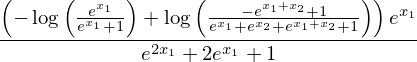

In [47]:
x1, x2, x3 = sp.symbols('x1 x2 x3')
#p1 = sp.exp(x1) / (1 + sp.exp(x1))
#p2 = sp.exp(x2) / (1 + sp.exp(x2))
p1 = 1 / (1 + sp.exp(-x1))
p2 = 1 / (1 + sp.exp(-x2))
h_sp = sp.simplify(-(p1*sp.log(p1) + p2*sp.log(p2) + (1 - p1 - p2)*sp.log(1 - p1 - p2)))

sp.simplify(sp.diff(h_sp, x1))


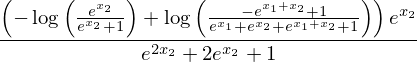

In [46]:
sp.simplify(sp.diff(h_sp, x2))

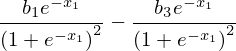

In [51]:
b1, b2, b3 = sp.symbols('b1 b2 b3')
eb_sp = b1 *p1 + b2*p2 + b3*(1-p1-p2)
sp.diff(eb_sp, x1)

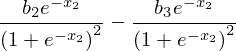

In [52]:
sp.diff(eb_sp, x2)

In [66]:
def logit(p):
    return np.log(p / (1 - p))

def x_to_p(x):
    """ inverse logit"""
    return np.e**(x) / (1 + np.e**(x))

def fun(x):
    lambdas = x_to_lambdas(x_to_p(x))
    return [my_entropy(lambdas) - H,
         np.dot(βs, lambdas) - Eβ]


def jac(x):
    block = np.log( (1 - np.e**(x[0] + x[1]) )   / (np.e**(x[0])+np.e**(x[1])+np.e**(x[0]+x[1]) + 1))
    num0 = (-np.log(  np.e**x[0] / ( np.e**x[0] + 1)) + block  )*np.e**x[0]
    den0 = np.e**(2*x[0]) + 2*np.e**(x[0]) + 1
    num1 =(-np.log(  np.e**x[1] / ( np.e**x[1] + 1)) + block  )*np.e**x[1]
    den1 =np.e**(2*x[1]) + 2*np.e**(x[1]) + 1
    
    dh_dx = np.array([num0/den0, num1/den1])
    
    deb_0 = ((βs[0] - βs[2])*np.e**(-x[0])) / (1 + np.e**(-x[0]))**2
    deb_1 = ((βs[1] - βs[2])*np.e**(-x[1])) / (1 + np.e**(-x[1]))**2
    deb_dx = np.array([deb_0, deb_1])
    
    return np.array([dh_dx, deb_dx])

sol = optimize.root(fun, logit(np.array([0.1, 0.01])), jac=jac)
print(sol.message)

lambdas_sol = x_to_lambdas(x_to_p(sol.x))
print(lambdas_sol)
print("Values: ", H, Eβ)
my_entropy(lambdas_sol), np.dot(βs, lambdas_sol)

/usr/local/anaconda3/envs/firm_learning/lib/python3.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in log


The solution converged.
[0.3112726886318943, 0.12745462273496724, 0.5612726886331385]
Values:  0.95 1.2


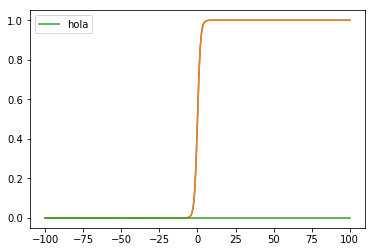

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
x = np.linspace(-100, 100, 1000)
y = np.e**x / ( 1 + np.e**x)
y2 = y = 1 / ( 1 + np.e**(-x))
plt.plot(x, y)
plt.plot(x, y2)
plt.plot(x, y -y2, label="hola")
plt.legend()

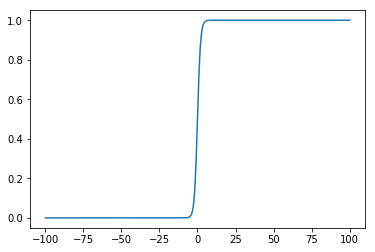

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
y = 1 / ( 1 + np.e**(-x))

plt.plot(x, y)